In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import time
import math
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


# Data preparation

In [ ]:
data_PATH = r'/content/drive/MyDrive/Datasets/data256/train'
label_PATH = r'/content/drive/MyDrive/Datasets/train.csv'

test_PATH = r'/content/drive/MyDrive/Datasets/data256/test'

submit_PATH = r'/content/drive/MyDrive/Datasets/test.csv'

df_train = pd.read_csv(label_PATH)
df_test = pd.read_csv(submit_PATH)
df_train['label'] = df_train['label'].astype('str')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(columns='label',axis=1),
                                               df_train['label'],
                                               test_size=0.2,
                                               shuffle=True,
                                               random_state=42)

df_train_cut = pd.concat([x_train,y_train],axis=1)
df_val_cut = pd.concat([x_val,y_val],axis=1)
print(x_train.shape, x_val.shape)

(6400, 1) (1600, 1)


In [ ]:
def DataGeneration(Height, Width, BatchSize):
    start_time = time.time()
    training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1./255,
                horizontal_flip = True,
                vertical_flip = True,
                #rotation_range = 30,
                brightness_range = [0.8,1.5],
                #zoom_range = [0.8,1.2],
                fill_mode = 'nearest')
    train_generator = training_datagen.flow_from_dataframe(
            dataframe = df_train_cut,
            directory = data_PATH,
            x_col = "name",
            y_col = "label",
            target_size = (Height, Width),
            batch_size = BatchSize,
            class_mode = 'binary',
            shuffle = True,
            seed = 42)

    validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1./255)
    val_generator = validation_datagen.flow_from_dataframe(
            dataframe = df_val_cut,
            directory = data_PATH,
            x_col = "name",
            y_col = "label",
            target_size = (Height, Width),
            batch_size = BATCH_SIZE,
            class_mode = 'binary',
            shuffle = True,
            seed = 42)

    print(f'----{time.time()-start_time} seconds----')
    return train_generator, val_generator

# Inception-ResnetV2

In [ ]:
def BuildModel():
    print('--------------Building The Model...--------------')
    base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(HEIGHT,WIDTH,3))
    base_model.trainable = True
    print("\nNumber of layers in the base model: ", len(base_model.layers))
    print(base_model.layers[0].output_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=out)

    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()
    print('\n--------------Done!--------------')
    return model

In [ ]:
def ModelDeployment(model, LearningRate, ModelName,  NbOfEpoch, StepsPerEpoch, ValidationSteps):
    ## Freeze all the layers before the `fine_tune_at` layer
    #for layer in base_model.layers[:fine_tune_at]:
    #    layer.trainable =  False
    print('--------------Deploying the Model...--------------')
    model.compile(loss = 'binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LearningRate),
                  metrics = 'accuracy')
    monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=1e-4, 
                                               patience=10, 
                                               verbose=1, 
                                               mode='min',
                                               restore_best_weights=True)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                        factor=0.5,
                                                        patience=3,
                                                        verbose=1,
                                                        mode='min',
                                                        min_delta=1e-4,
                                                        cooldown=0,
                                                        min_lr=MIN_LR,)

    filepath= ModelName+"-{epoch:02d}-{val_loss:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                    monitor='val_loss', 
                                                    verbose=1, 
                                                    save_best_only=False, 
                                                    save_weights_only=True, 
                                                    mode='min',
                                                    save_freq = 'epoch')
    print('--------------Deployed Successfully--------------')
    print('--------------Training Begins--------------')
    history = model.fit(train_generator, 
                            epochs = NbOfEpoch, 
                            steps_per_epoch = StepsPerEpoch, 
                            validation_data = val_generator, 
                            verbose = 1, 
                            validation_steps = ValidationSteps,
                            callbacks = [monitor,lr_scheduler,checkpoint])
    return history

In [ ]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 16

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
----45.803587675094604 seconds----


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def HistoryPlotting(history):
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(history.history['loss'],label='train',color='blue')
    ax.plot(history.history['val_loss'],label='val',color='green')
    ax.set_title('model loss',fontsize=14)
    #ax.set_yticks()
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    #ax.set_xticks(range(0,20))
    ax.legend(loc='upper right',fontsize=13)

In [ ]:
InceptionResNetV2_based_model = BuildModel()
InceptionResNetV2_based_model.summary()

--------------Building The Model...--------------
219062272/219055592 [==============================] - 1s 0us/step

Number of layers in the base model:  780
[(None, 256, 256, 3)]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (

In [ ]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
#STEPS_PER_EPOCH = 200
VALIDATION_STEPS = val_generator.n//BATCH_SIZE
#VALIDATION_STEPS = 50
LEARNING_RATE = 1e-5
NB_EPOCH = 50
#FINETUNE_LEARNING_RATE = LEARNING_RATE/10
MIN_LR = 1e-8 
#fine_tune_at = 200
InceptionResNetV2_history = ModelDeployment(model = InceptionResNetV2_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'InceptionResNetV2',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------
Epoch 1/50
400/400 [==============================] - 1980s 5s/step - loss: 0.4545 - accuracy: 0.7921 - val_loss: 0.1209 - val_accuracy: 0.9556

Epoch 00001: saving model to InceptionResNetV2-01-0.1209.hdf5
Epoch 2/50
400/400 [==============================] - 181s 452ms/step - loss: 0.1254 - accuracy: 0.9570 - val_loss: 0.0748 - val_accuracy: 0.9756

Epoch 00002: saving model to InceptionResNetV2-02-0.0748.hdf5
Epoch 3/50
400/400 [==============================] - 180s 450ms/step - loss: 0.0785 - accuracy: 0.9714 - val_loss: 0.0581 - val_accuracy: 0.9794

Epoch 00003: saving model to InceptionResNetV2-03-0.0581.hdf5
Epoch 4/50
400/400 [==============================] - 181s 452ms/step - loss: 0.0480 - accuracy: 0.9830 - val_loss: 0.0531 - val_accuracy: 0.9837

Epoch 00004: saving model to InceptionResNetV2-04-0.0531.hdf5
Epoch 5/50
400/400 [=

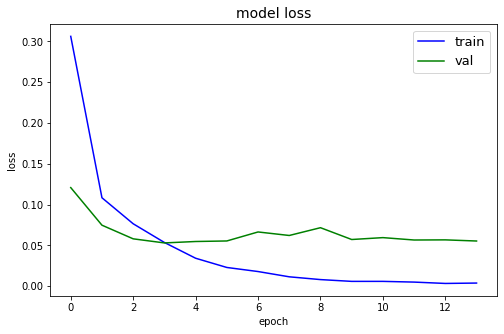

In [ ]:
HistoryPlotting(InceptionResNetV2_history)

In [ ]:
from keras.models import load_model

weights_path = '/content/InceptionResNetV2-09-0.0717.hdf5'

model = InceptionResNetV2_based_model
model.load_weights(weights_path)

In [ ]:
pic = '/content/drive/MyDrive/Datasets/data256/train/train_2676891789267.png'
#model = load_model('/content/weights-24.hdf5')
X = []
X.append(cv2.resize(cv2.imread(pic),dsize=(256,256)))
X = np.array(X)
X = X/255
predictions = model.predict(X)
print(predictions)

[[0.8941288]]


In [ ]:
start_time = time.time()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe = df_test,
        directory = '/content/drive/MyDrive/Datasets/data256/test',
        x_col="name",
        target_size = (HEIGHT, WIDTH),
        batch_size = 1,
        shuffle = False,
        class_mode = None)
print(f'----{time.time()-start_time} seconds----')
## very important
test_generator.reset()

Found 12000 validated image filenames.
----2.2763705253601074 seconds----


In [ ]:
pred = model.predict(test_generator,steps=len(df_test))

In [ ]:
df_submit = pd.DataFrame({"name":df_test['name'],'pred':pred.flatten()})
df_submit.to_csv("submision.csv",index = False)
df_submit.head(20)

,name,pred
0,test_1000183618656797.png,1.000000e+00
1,test_1000393965653244.png,2.156343e-01
2,test_100071345206782.png,1.000000e+00
3,test_100100998368010.png,7.667757e-14
4,test_1001897299647728.png,9.995067e-01
5,test_1002185713934821.png,9.968163e-01
6,test_1003087301733830.png,1.132561e-05
7,test_1004381477443244.png,4.082469e-03
8,test_1004793951488314.png,1.154400e-02
9,test_1005172244305045.png,6.725540e-03
